In [1]:
suppressPackageStartupMessages(
    {
    library(tidyverse)
    library(nflverse)
    library(gganimate)
    library(cowplot)
    library(magick)
    library(patchwork)
    library(gghighlight)
    }
)

In [2]:
games = read.csv("/kaggle/input/nfl-big-data-bowl-2025/games.csv")
plays = read.csv("/kaggle/input/nfl-big-data-bowl-2025/plays.csv")
players = read.csv("/kaggle/input/nfl-big-data-bowl-2025/players.csv")
player_play = read.csv("/kaggle/input/nfl-big-data-bowl-2025/player_play.csv")

In [3]:
# selecting only relevant columns as a Look Up Table
lut = plays %>% 
    select(playId, gameId, offenseFormation, receiverAlignment, absoluteYardlineNumber, 
           yardsGained, down, yardsToGo, possessionTeam, passResult, playDescription) %>%
    mutate(runPassFlag = if_else(passResult == '', "R", "P"))

players = players %>%
  select(nflId, height, weight, position, displayName)

dim_motion = player_play %>%
    filter(inMotionAtBallSnap == TRUE) %>%
    select(gameId, playId, nflId, inMotionAtBallSnap) %>%
    inner_join(lut, by = join_by(playId == playId, gameId == gameId))

In [4]:
transform_week = function(wkX_csv) {
    wkX = read.csv(wkX_csv)

    # combine lookup tables/dimensions with play-by-play
    all_motion_plays = inner_join(dim_motion, wkX, by = join_by(playId == playId, gameId == gameId, nflId == nflId))

    # calculate start of motion
    frame_mtn_starts = all_motion_plays %>%
        filter(event == 'man_in_motion') %>%
        select(gameId, playId, frameId) %>%
        distinct(gameId, playId, .keep_all = TRUE)

    # filter down motion play frames to only where the player is physically in motion
    all_motion_plays = inner_join(all_motion_plays, frame_mtn_starts, 
                                  by = join_by(playId == playId, gameId == gameId)) %>%
        filter(frameId.x >= frameId.y & frameType == 'BEFORE_SNAP')

    # summarize each play to calculate the change in (x, y) coordinate for the pre-snap motion + top speed
    # ignoring player here since each play can only have 1 player in motion at snap, thus play = player level grain here
    mtn_xy = all_motion_plays %>%
        group_by(gameId, playId, nflId) %>%
        mutate(
            distance = sqrt( # calculating euclidean distance b/w each x,y and sum total to get total dist covered
                (x - lag(x, default = first(x)))^2 +
                (y - lag(y, default = first(y)))^2),
            cumulative_distance = cumsum(replace_na(distance, 0))
        ) %>%
        summarize(
            x_start = first(x),
            x_fin = last(x),
            y_start = first(y),
            y_fin = last(y),
            max_speed = max(s),
            avg_speed = mean(s),
            o_fin = last(o),
            dir_fin = last(dir),
            ttl_dist = max(cumulative_distance),
            .groups = 'drop_last'
        ) %>%
        mutate( # separating for clarity, need to adjust signs still
            mtn_chg_x = x_fin - x_start,
            mtn_chg_y = y_fin - y_start
        ) %>%
    select(gameId, playId, nflId, mtn_chg_x, mtn_chg_y, max_speed, avg_speed, ttl_dist) %>%
    distinct(gameId, playId, .keep_all = TRUE) # some plays have multiple manInMotion == TRUE

    ######################################### end motions #############################################

    # starting with the position of the football at the snap
    # this is the main dataframe I will join the individual pieces back to
    wkX_lateral_mvmt = wkX %>% 
        filter(displayName == 'football' & event == 'ball_snap') %>%
        inner_join(lut, by = join_by(playId == playId, gameId == gameId)) %>%
        inner_join(plays, by = join_by(playId == playId, gameId == gameId))

    # scenario 1
    last_pos_football = wkX %>%
        filter(displayName == 'football' & frameType == 'AFTER_SNAP') %>%
        group_by(gameId, playId) %>%
        summarize(lastFrame = max(frameId), .groups = 'drop_last') %>%
        inner_join(wkX, by = join_by(playId == playId, gameId == gameId, lastFrame == frameId)) %>%
        filter(displayName == 'football') %>%
        select(gameId, playId, x, y) %>%
        rename(last_x = x, last_y = y)

    # scenario 2
    pos_at_contact = wkX %>%
        filter(displayName == 'football' & event == 'first_contact') %>%
        select(gameId, playId, x, y) %>%
        rename(contact_x = x, contact_y = y)

    # joining scenarios 1-2 back to main and adding logic to pick the relevant scenario
    wkX_lateral_mvmt = wkX_lateral_mvmt %>%
        left_join(last_pos_football, by = join_by(playId == playId, gameId == gameId)) %>%
        left_join(pos_at_contact, by = join_by(playId == playId, gameId == gameId)) %>%
        mutate(
            final_y = case_when(
                runPassFlag == 'P' & passResult.x %in% c('C','I','IN') ~ targetY, # .x needed because of play data join
                (runPassFlag == 'R' & yardsGained.x < 0) ~ last_y,
                !is.na(contact_y) ~ contact_y, # prefer contact_y over last_y on gains, but sometimes no contact
                TRUE ~ last_y
            ) # end case
        ) %>% 
        mutate(
            direction_team_POV = case_when(
                playDirection == 'right' & final_y < y ~ 'right',
                playDirection == 'right' & final_y >= y ~ 'left',
                playDirection == 'left' & final_y > y ~ 'right',
                playDirection == 'left' & final_y <= y ~ 'left'
            ), # end case
            absolute_diff_y = final_y - y, 
            change_in_y_during_play = case_when( # have to flip the signs to normalize data b/w direction of play
                playDirection == 'right' ~ -absolute_diff_y,
                TRUE ~ absolute_diff_y
            ) # end case
        ) %>%
        select(gameId, playId, change_in_y_during_play, playDirection, direction_team_POV) 

    ##### end results #####

    # circling back to adjust sign of motion directions (needed play direction in data frame to do so) and joining the sections
    combined_results = inner_join(mtn_xy, wkX_lateral_mvmt, by = join_by(playId == playId, gameId == gameId)) %>% 
    mutate(
        mtn_chg_x = case_when(
            playDirection == 'left' ~ -mtn_chg_x,
            TRUE ~ mtn_chg_x
        ), # end case
        mtn_chg_y = case_when(
            playDirection == 'right' ~ -mtn_chg_y,
            TRUE ~ mtn_chg_y
        ) # end case
    ) %>% 
    mutate(
        mtn_dir_team_POV = case_when(
            playDirection == 'left' & mtn_chg_y < 0  ~  'left',
            playDirection == 'left' & mtn_chg_y >= 0  ~  'right',
            playDirection == 'right' & mtn_chg_y > 0  ~  'right',
            playDirection == 'right' & mtn_chg_y <= 0  ~  'left'
        ), # end case
        play_vs_motion = case_when(
            direction_team_POV == mtn_dir_team_POV ~ 'Same',
            TRUE ~ 'Opposite'
        ) # end case
    ) %>%
    ungroup()

    # calculate the x value of LOS to use in plots
    LOS = wkX %>%
    filter(event == 'ball_snap' & displayName == 'football') %>%
    select(gameId, playId, x) %>%
    rename(LOS = x)

    combined_results = combined_results %>%
        inner_join(LOS, join_by(playId == playId, gameId == gameId)) 

    return(combined_results)
}

In [5]:
wk1 = transform_week('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_1.csv')
wk2 = transform_week('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_2.csv')
wk3 = transform_week('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_3.csv')
wk4 = transform_week('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_4.csv')
wk5 = transform_week('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_5.csv')
wk6 = transform_week('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_5.csv')
wk7 = transform_week('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_5.csv')
wk8 = transform_week('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_5.csv')
wk9 = transform_week('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_5.csv')

weeks_to_merge = list(wk1, wk2, wk3, wk4, wk5, wk6, wk7, wk8, wk9)

dt = do.call(rbind, weeks_to_merge) %>%
    inner_join(players, by = join_by(nflId == nflId)) %>%
    inner_join(lut, by = join_by(playId == playId, gameId == gameId)) %>%
    mutate(across(where(is.character), factor)) %>%
    drop_na() %>%
    mutate(
        runPassFlag = case_when(
            runPassFlag == 'R' ~ 'RUN',
            TRUE ~ 'PASS'
        ) # end case
    )

**Motivation**  
In this analysis we will investigate the effect of pre-snap motion on play outcomes. Specifically, we will evaluate whether plays where the ball is snapped *with a player actively in motion* have actionable tendencies that could be used by defensive players on the field in real time.

A simple exercise to motivate the framework is to imagine the job of an inside linebacker seconds before the ball is snapped. They are quickly polling their recollection of the scouting report in the context of the current formation, personell group, down & distance, and game state. Simple heuristics like 3 tight ends on the field = RUN or backup QB in the game = PASS can be invaluable shortcuts for players tasked with processing this mountain of dynamic inputs under fatigue.

Players already maintain many heuristics about offensive tendencies (passes are likely on 3rd and 15 for example) so the goal of this analysis is to extend that concept to less intuitive actions and create new contextual hueristics for run/pass and left/right in response to pre-snap motion.

Based on the 2022 dataset, about 25% of plays are begin with a player in motion, so these heuristics could be very impactful if implemented in defensive prep with very minimal effort. 

For reference, the chart below illustrates the volume of plays snapped with a player in motion relative to all plays in the 2022 player tracking dataset:

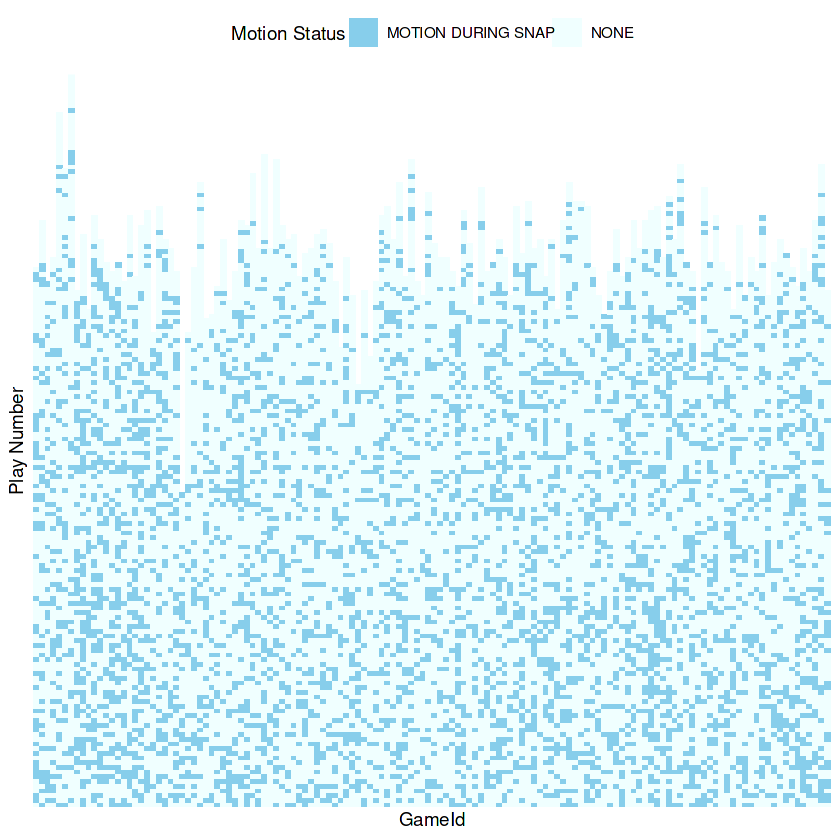

In [6]:
plays_in_seq = lut %>% 
    arrange(gameId, playId) %>%
    group_by(gameId) %>%
    mutate(
        play_num = row_number()
    ) %>% 
    ungroup()

plays_w_mtn = plays_in_seq %>%
    inner_join(player_play, by = join_by(playId == playId, gameId == gameId)) %>%
    filter(inMotionAtBallSnap == TRUE) %>%
    distinct(gameId, play_num) %>%
    mutate(
        mtn = 'MOTION'
    )

left_join(plays_in_seq, plays_w_mtn, by = join_by(gameId == gameId, play_num == play_num)) %>%
    mutate(
        mtn = case_when(
            mtn == 'MOTION' ~ 'MOTION DURING SNAP',
            TRUE ~ 'NONE'
        ) # end case
    ) %>%
    arrange(gameId, playId) %>%
    ggplot(aes(as.factor(gameId), as.factor(play_num), fill = as.factor(mtn))) +
    geom_tile() + 
    scale_x_discrete(
        name = 'GameId',
        labels = c(),
        breaks = c()
    ) +
    scale_y_discrete(
        name = 'Play Number',
        labels = c(),
        breaks = c()
    ) +
    scale_fill_manual(
        values = c('MOTION DURING SNAP' = 'skyblue', 'NONE' = 'azure') 
    ) +
    theme_minimal() +
    theme(legend.position = "top") +
    labs(fill = "Motion Status") +
    theme(
        axis.text.x = element_text(size = 20),
        axis.text.y = element_text(size = 20)
    )

**Inputs**  
First we start by isolating the pre-snap motion. While there might be several motions that occur prior to the snap, we can easily identify the motion that was in progress at the time of the snap through flags in the tracking data. Since only one player can be in motion at a time (else it would be an illegal shift penalty) this is a trivial data manipulation exercise.

With the relevant motions identified, we can engineer some basic features for analysis. First and foremost, we identify the starting (x, y) coordinate for the player at the time the line was set, and the final (x, y) coordinate at the end of the motion. By looking at the frames between those two points in time, we can calculate the total distance covered by the motion, the change in (x, y), top speed, and average speed.

To illustrate the process, I will walk through a few charts with a single play and then generalize how that relates to the overall dataset before showing the results.

**Outputs**  
For simplicity, we can reduce the target variables to only play type RUN/PASS and play direction LEFT/RIGHT. We will assume any play with a rushing attempt is a run (this includes scrambles) and any play with a passing target is a pass.

For passing plays, the direction of the play could reasonably be calculated many different ways. For example, given a trips-left formation where the offense 1) runs three out-routes at different depths in a flood concept and 2) targets the weakside tight end on a curl, we could argue that the intended direction of the play was LEFT (towards the three outs) even though the football/target went RIGHT.

Again simplifying where possible, we will only consider the (x, y) position of the target for play direction on passes. 

For run plays, however, we will use a combination of two points depending on the play. We would prefer to only use the ending (x, y) position of the football, but cutbacks and other ball carrier actions complicate whether that fairly represents the intended direction of the play. To shorten the opportunity for such confounding actions, we will instead prefer the position of first contact between the ball carrier and a defender. For the run plays ending in a positive gain, we will use the first point of contact. For plays resulting in a loss, we will use the ending position of the football.

In summary, we calculate the LEFT/RIGHT movement of the play based on the following scenarios:
  * Scenario 1: run for loss $\rightarrow$ end position of football  
  * Scenario 2: run for gain $\rightarrow$ position of first contact  
  * Scenario 3: pass attempt $\rightarrow$ position of target

For reference, the final dataframe containing all inputs/outputs by play is shown below:

In [7]:
head(dt)

gameId,playId,nflId,mtn_chg_x,mtn_chg_y,max_speed,avg_speed,ttl_dist,change_in_y_during_play,playDirection,⋯,offenseFormation,receiverAlignment,absoluteYardlineNumber,yardsGained,down,yardsToGo,possessionTeam,passResult,playDescription,runPassFlag
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<chr>
2022090800,80,47857,-2.88,-4.16,5.09,3.768889,9.646184,9.869999,left,⋯,EMPTY,3x2,79,7,2,4,BUF,R,"(14:29) (No Huddle, Shotgun) J.Allen scrambles right end to BUF 38 for 7 yards (E.Jones).",PASS
2022090800,101,53079,-0.19,1.56,3.79,1.917778,1.574407,11.570000,left,⋯,I_FORM,2x1,72,7,1,10,BUF,,(13:54) D.Singletary right end to BUF 45 for 7 yards (T.Hill).,RUN
2022090800,212,47879,-0.32,5.08,7.06,6.285556,5.090312,16.150001,left,⋯,SHOTGUN,2x2,44,8,2,9,BUF,C,(10:42) (Shotgun) J.Allen pass short right to Z.Moss to LA 26 for 8 yards (B.Wagner).,PASS
2022090800,236,52536,0.26,-2.84,3.90,3.537778,2.855992,13.930001,left,⋯,I_FORM,2x1,36,26,3,1,BUF,C,"(10:03) J.Allen pass short right to G.Davis for 26 yards, TOUCHDOWN.",PASS
2022090800,299,44881,-0.71,-3.37,6.69,5.690000,3.444676,-3.910000,right,⋯,SINGLEBACK,2x2,27,5,1,10,LA,,(9:52) D.Henderson up the middle to LA 22 for 5 yards (G.Rousseau).,RUN
2022090800,438,53678,-0.63,-3.20,6.44,5.397143,3.261685,-22.540001,right,⋯,SINGLEBACK,2x2,63,4,1,10,LA,C,(6:48) M.Stafford pass short left to B.Skowronek pushed ob at BUF 43 for 4 yards (C.Benford).,PASS


# One Play Example

As described in the data, the play shows a motion across the formation by Amon-Ra St. Brown, resulting in a swing pass to De'Andre Swift to the motion side.

First, a quick animation to visualize the play in action:

*h/t to https://michael-morris.us/2020/10/nfl-big-data-bowl-2021-exploration.en-us/ for the animation template*

In [8]:
wk1_raw = read.csv('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_1.csv')

example.play = wk1_raw %>% 
  filter(gameId ==	2022091104 & playId == 58) %>%
  inner_join(lut, by = join_by(playId == playId, gameId == gameId))

## General field boundaries
xmin <- 0
xmax <- 160/3
hash.right <- 38.35
hash.left <- 12
hash.width <- 3.3


## Specific boundaries for a given play
ymin <- max(round(min(example.play$x, na.rm = TRUE) - 10, -1), 0)
ymax <- min(round(max(example.play$x, na.rm = TRUE) + 10, -1), 120)
df.hash <- expand.grid(x = c(0, 23.36667, 29.96667, xmax), y = (10:110))
df.hash <- df.hash %>% filter(!(floor(y %% 5) == 0))
df.hash <- df.hash %>% filter(y < ymax, y > ymin)

animate.play <- ggplot() +
    scale_size_manual(values = c(6, 4, 6)) +
    scale_shape_manual(values = c(21, 16, 21)) +
    scale_fill_manual(values = c("#0076B6", "#815337", "#004C54")) +
    scale_colour_manual(values = c("#815337", "#815337", "black")) +
    annotate("text", x = df.hash$x[df.hash$x < 55/2],
           y = df.hash$y[df.hash$x < 55/2], label = "_", hjust = 0, vjust = -0.2) +
    annotate("text", x = df.hash$x[df.hash$x > 55/2],
           y = df.hash$y[df.hash$x > 55/2], label = "_", hjust = 1, vjust = -0.2) +
    annotate("segment", x = xmin,
           y = seq(max(10, ymin), min(ymax, 110), by = 5),
           xend =  xmax,
           yend = seq(max(10, ymin), min(ymax, 110), by = 5)) +
    annotate("text", x = rep(hash.left, 11), y = seq(10, 110, by = 10),
                    label = c("G   ", seq(10, 50, by = 10), rev(seq(10, 40, by = 10)), "   G"),
                    angle = 270, size = 4) +
    annotate("text", x = rep((xmax - hash.left), 11), y = seq(10, 110, by = 10),
           label = c("   G", seq(10, 50, by = 10), rev(seq(10, 40, by = 10)), "G   "),
           angle = 90, size = 4) +
    annotate("segment", x = c(xmin, xmin, xmax, xmax),
           y = c(ymin, ymax, ymax, ymin),
           xend = c(xmin, xmax, xmax, xmin),
           yend = c(ymax, ymax, ymin, ymin), colour = "#815337") +
    geom_point(data = example.play, aes(x = (xmax-y), y = x, shape = club,
                                       fill = club, group = nflId, size = club, colour = "#815337"), alpha = 0.7) + 
    geom_text(data = example.play, aes(x = (xmax-y), y = x, label = jerseyNumber), colour = "white", 
              vjust = 0.36, size = 3.5) + 
    ylim(ymin, ymax) + 
    coord_fixed() +  
    theme_nothing() + 
    theme(plot.title = element_text()) +
    transition_time(frameId)  +
    ease_aes('linear') + 
    NULL

play.length.ex <- length(unique(example.play$frameId))

suppressWarnings({
    animate.play <- invisible(animate(animate.play, fps = 10, nframe = play.length.ex))
})

anim_save("animation.gif", animate.play)

In [9]:
suppressWarnings({
    animation <- image_read("animation.gif")
    print(animation, info = F)
    })

<img src="data:image/gif;base64,R0lGODlh4AHgAff/AAAAAAgICA8PDxQUFBgYGBoaGhsbGx8fHyIiIicnJykpKS0tLTAwMDMz
Mzc3Nz4+PkQzKVA+NFpJP29POwxARRVJThxOUh9UWTdIQjxNRiNYXThUUCpeYz9lZDRobTds
cD1xdUFBQUREREpKSkxMTE9PT09WS1NTU1dXV1lZWV1eWnBfVGdqXmdrX3tiU3loXlJja110
b0doeFNtckN4fVd3dVp1clZ6eVJ8fmJiYmRkZGZmZmVsYmJuZWhoaGtqaWtra3tqYGBxam9y
cGd3fnR0dHV1dXZ2dnd3d3t6eoFTN4xtWoZ1apZ1YJl4Y5t6ZZ9+aYZ7dIB/foeBfKKBbKWE
b6eHc6yOexJhjBxvnDltiDF3nQl1rxpzpAZ5uBB8txx+tCF7rEdugk9+gU16k2d5gmZ+iheC
vRqEvjeCqiuKvj2Js06BhU2Ch1CEiVWHjFqKj16ClV6Gm2yMlmORlmuXm3eRlHKbn0mDolqM
p0ORvFWTtFKYvmWdunqgpH2jqDSRxEKYx0ybx02fzFSizFymz3qwzWqt0ny32IKCgoaGhoeH
hoiJgYiIiIqKipuLgJSUlJeXlp6enqmShKiViKiWjL2llbGimL+nmYKnq4emqYaqrousr5Kl
q5uqrY6ws5OytZq4u6GhoKqqqq+vr6C5u7CwsLKysrS0tLi4uLu7u76/vsGqnMSuoMeypcm2
qcy6rs69sdC/tNPCuNTFu9fIv4iyyYm92aS/xI3B3avFx7HCxLXLzbrO0JjH4J7J4avQ5LfY
6cLCwcLEw8XHxsbIyMvLy8zMzNnLw9vOxt7SysLQ0cTV18vY2cjZ2szb3NbV1NrX1dDe39nZ
2dvb293d3eHWz+Ta1Ofd2Ojg2+vk38La5sLd7Mjh783h7NPh4tnk5t3n6N/o6tHm8dbp9N3s
9ePj4+fk4uXl5e3n4u7p5+Pr7Obt7+7u7vLt6vXx7+nv8OXw9+rw8e7z9fHw8PLy8vX09Pj2
9PD1+PX4+vr5+fv7+/z8/P39/v/+/v///yH5BAQKAAAAIf4HZ2lmLnNraQAh/wtORVRTQ0FQ
RTIuMAMBAAAALAAAAADgAeABAAj+AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mix
o8ePIEOKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0
qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3
r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqKUK+1Fi
hA9VqYlWKxIbqKIGkE6dguQgUW2e9IIHN0ag3e+eBuoR3KfguE4B0KMPMDDNuc4E1QeiW2C9
e95TBlL+JCmSwgApxPvOqV/Pvr379/Djy59Pv779+/jz69/Pv7///wAGOF80kSSRRCTQCKjg
gvXto9IkSkQo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oosKjGJSlXM0hUpBKRQ
RBEoGICKd5zNUgWMMnK1wDkETZMAjzZNY0B0THLlI5BdKeDgQPYYgKRN7RhgjHDBOfljSjF2
lYgDkegGSQONXGlTEdWE9SSYQXKVyg4jlPCDMGpm9iZKYebpJ1F7ntTnn4T+FKhJT7xw46LG
+Dnbojc2etKjkEqqJqU3vtAElIV2ytOhJQ3q6ag2gUqSqKSmGpOpI6Gq6qv+LLEqkquw1nqS
rCHRauuuIuEKkq68BtuRrx8lCmkRll6JaaQoLYuso8dqyqmw1H5ErEfAVqstRdd2lO224D7U
LUffhmuuQuNuVO657BaUrkbrtivvuxnFKy+79GJkbKXQHpssSc7+y+Oy0sJ578EJ5XuRvQiD
q7BFDDes7cMVRSwxtRRTZPHFwWY80cYc7+qxRCCHXOvIEZVs8qsoQ7Qvo/3yO+mxz+ZJ8KYG
r3xvyw+prDOpPDvk88+eBt3Q0EQXajRDSCf959ILNe10nlArRMUlx2St9dZcd+3112CHLfbY
YRtD9tlop6322mobYzbbcMct99x012333XVfQoX+Sk5AgMDfgAcu+OCEF2744YgnrvjijDfu
+OOQRy755JRXbvnlmGeeOQROTDv1tlUnJPXnSIaO0Oike2f6Qainbt3qBrXu+nGwFyT77LXV
TtDtuKem+0AvM2szzQKLFHDMmeLMZ5y9i/zl8s13/LygzEcP6+8C8W49adj/o/32onX/Pfig
iV89+aN2H3zNlxLfrPvDQ1ow9Nbxo0426vCDPkPmO2cPLGWIgxziUAZYvOMf/LgGLFrhilq4
Y3//6N9vtEGEPQzighfcAxFoYQk58EEQgtiDGSzRijKYsBXXiJ4EY0OPMgiCEIXA4AUNMQML
BiMe5TCEGbSQBgwKQg7+rLBH71aYGkzwYRC/+IUMD8EPPZQBEd0YBCKmEYYzgGENfLBFHuSQ
B0tMyXVEPE06zDCIceRDiYMgBCG4QQ5AaMEWUfTDNs5whjDIYA7/WMMWxFAES+AujKZBhgWR
iEZBBEMQ3gBEGOQwjnjkIxBn2IIMwsCNcQCCjmCQQSxmpz5FySw0+ovFEQl5wVsAIwyJBEMn
xtGHTXCjCzIAxjzK4Q01oOEX4yhHJ1IYkuPFb1Hzo15q9CeLQSbxgrnkRj7IoYde5EIOYYiH
GA4RjFwQAh+AKEQwzhCIeRABjNMzyfgOo4w8XDCJgQiEHrvQDUBsARfBiIMe4qGFQHRjHOP+
+Mc4EFEIOsYjD9ZIHSBLc48yXNAXtwgDGNCABi5wYw0yEAQ31rGOPmTBC164RTnGoQYueLQQ
3OADLAQazlCdzzSyyIMgflEOcgiCjr8gxzikYEE+iEELXcAoIG4xDzV44Qu58EYa1sAKknoO
NfzAxB+2ucYzaDMLduBGRAdhBjFkgRAd/QI+fsqNYHijHHy4glFzVptkRIIZYBgEN8DQh2W8
YA7b2EIcBsEHGGjhFrfI6Dy8cAhgcIOb2xhCNkg3UNOwQqLs2IcZciCGbZQjH3SAQQ7MQEAY
gCEY+fiHL7zwC3zYoxzlEAMfivq5TvrrNGW4BSv3sY94dIMbgOj+Rj7GYQYykMEGLoBBFrpg
CEN0IQy3CAY51tEJqt7jI75sn/yUJ8zflCEYtyACN+Jxhl8cog83HMQ2iCAIusJADGdABCLo
6AtubGEK8yjDD2DxRaIVtjRl+MUx9nDD8HojHvvgBz+6Idc1pCELMICBLcZ7Blt4AgbRVMMi
iRDQpL2XKkM4j0BMcYyktGIQvXBkLgsBDHLkIx7/AMQXYCDeL3RBDJ64xAt+cIp8lOMQ5agu
Dv2ADL8MgzUj2AFsvHRUrADgASoQSBIMIAmkXCMOYghEPwMRDy6oFbqgdRA/AIEIeOADH/zY
AzhKsY58DKIQ25AibbXBl9vkZje94TH+WbUSgH+MYBQCQUdzkGIJ8NLxDNT1BSKCwYVyfEEG
GtUoO9ixX0PgExxzOEMfuCFmQZBWLwYQ4kDuMWetPHgqbTYHAujxD3oMICnvmEEucsHNcngB
ES5VQzy8IINx/CKnWUjDPAIRjI3G4xtaWEMj93GIQZRBOXrBDkG2o2b6baXN/4jEA0iBghMo
BRN6CAY+9/DTZbqUC3Eghy0wqoVtdIMLwPDGFwaxDxkgYhyHyMU4BiEHbOwFFeG5UY5OUeyT
UKESqsi3vvfN7377+98AD7jAB07wfDdA30NoQAlIUfCGO/zhA78EGfybhi1wgdZf4IIXtPAL
XxgCo3GIhyD+uIAIQ2g0HlvghSHWsIZ46IEMl4C4zGdO85rbXBWmSMIOclCEU9z850CHeCX2
lpInRKABSE+60pfO9KY7/elQj7

Now simplifying the play into the two components of interest.

1) the input: where does the motion go?
2) the output: where does the ball go?

Each chart shows the frame by frame of the motion (top) and the ball (bottom) with the starting point colored in black, progressively lightening over the course of the play.

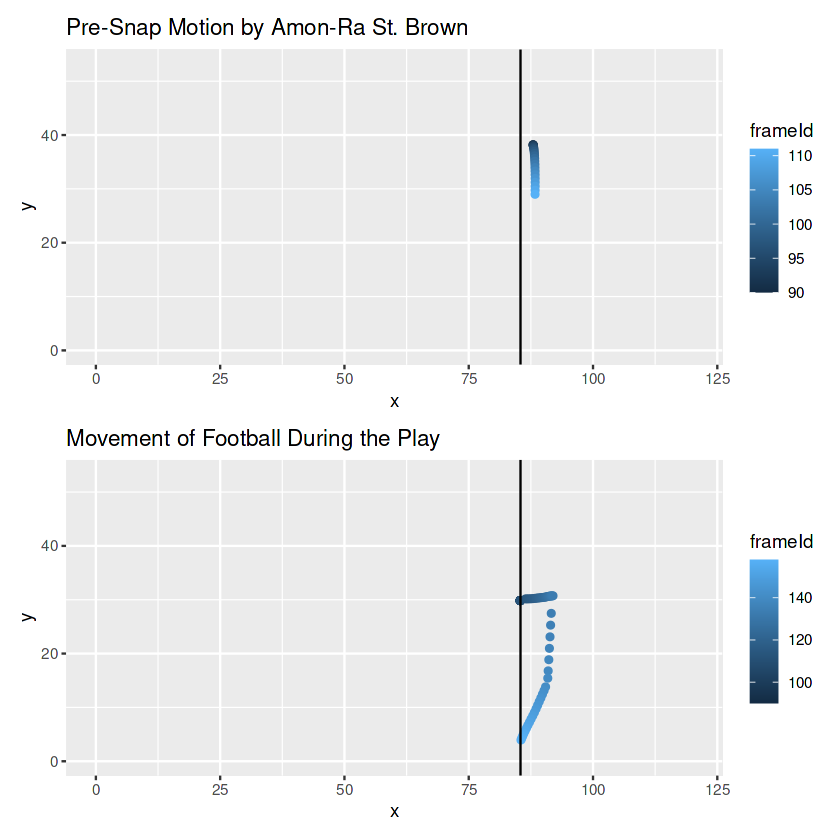

In [10]:
pick_play = 58
pick_game = 2022091104 

motion_frame = wk1_raw %>%
  filter(gameId == pick_game & playId == pick_play & event == 'man_in_motion') %>%
  select(gameId, playId, frameId) %>%
  pull(frameId)

motion_start = motion_frame[1]

snap_frame = wk1_raw %>%
  filter(gameId == pick_game & playId == pick_play & event == 'ball_snap') %>%
  select(gameId, playId, frameId) %>%
  pull(frameId)

snap = snap_frame[1]

LOS = wk1_raw %>%
  filter(gameId == pick_game & playId == pick_play & event == 'ball_snap' & displayName == 'football') %>%
  pull(x)

motion_plot = wk1_raw %>%
    filter(gameId == pick_game & playId == pick_play) %>%
    inner_join(player_play, by = join_by(playId == playId, gameId == gameId, nflId == nflId)) %>%
    filter(inMotionAtBallSnap == TRUE & frameId >= motion_start & frameId <= snap) %>%
    ggplot(aes(x=x, y=y, group=frameId, color = frameId)) +
    geom_point() +
    ggtitle('Pre-Snap Motion by Amon-Ra St. Brown') +
    geom_vline(xintercept = LOS) +
    scale_x_continuous(limits = c(0, 120)) +
    scale_y_continuous(limits = c(0, 53.3))

ball_plot = wk1_raw %>%
    filter(gameId == pick_game & playId == pick_play) %>%
    filter(displayName == 'football' & frameId >= motion_start) %>%
    ggplot(aes(x=x, y=y, group=frameId, color = frameId)) +
    geom_point() +
    ggtitle('Movement of Football During the Play') +
    geom_vline(xintercept = LOS) +
    scale_x_continuous(limits = c(0, 120)) +
    scale_y_continuous(limits = c(0, 53.3))

motion_plot /
ball_plot

Generalizing the same approach across the entire dataset, we plot the given Amon-Ra motion alongside every motion that is captured in the data. We can see there are motions of varying lengths, from varying field positions, going in both directions, and each with their own unique depths. Even this view is simplifying the actual dimensionality quite a bit as I am ignoring many details, principally, the player (RB vs WR, etc.) and speed.

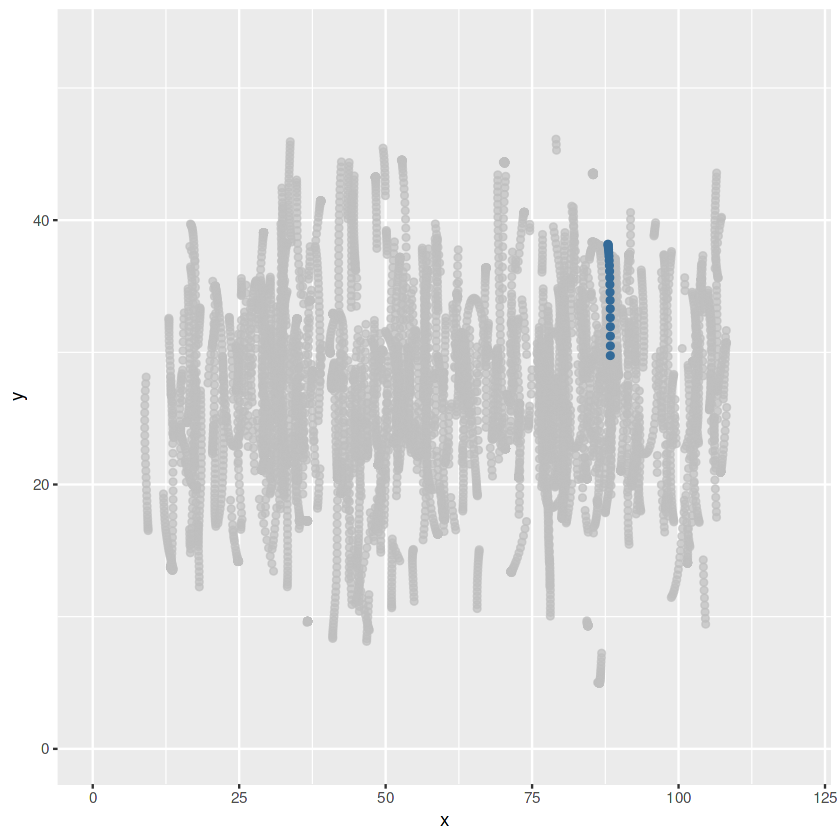

In [11]:
suppressWarnings({
    frames_of_snaps = wk1_raw %>%
        filter(event == 'man_in_motion') %>%
        distinct(gameId, playId, frameId) 
    
    frames_of_snaps = frames_of_snaps %>% rename(mtn_start = frameId)

    wk1_raw %>%
        inner_join(player_play, by = join_by(playId == playId, gameId == gameId, nflId == nflId)) %>%
        inner_join(frames_of_snaps, by = join_by(playId == playId, gameId == gameId)) %>%
        filter(inMotionAtBallSnap == TRUE & frameType == 'BEFORE_SNAP' & frameId > mtn_start) %>%
        ggplot(aes(x=x, y=y, group=gameId,playId, color=gameId,playId)) +
        geom_point() +
        gghighlight(gameId ==	2022091104 & playId == 58, use_direct_label = FALSE) +
        scale_x_continuous(limits = c(0, 120)) +
        scale_y_continuous(limits = c(0, 53.3)) +
        theme(legend.position = 'none')
    })

To visualize the overall relationship between each motion and play movements, we will plot plays in two dimensions where the x axis represents the lateral movement of the player's pre-snap motion and the y axis represents the horizontal movement of the football during the play.

In this context, we are ignoring the depth of the motion and also the vertical movement in the play. A simple jet motion would look identical to an orbit motion (as long as the side-to-side movement is equal) and a 50 yard pass attempt would look identical to an inside run (as long as the side-to-side movement is equal). Focusing on the relationship between these simplified components of each play, we can observe some basic heuristics for how teams behave with players in motion. 

In data science terms, this process is analagous to assuming the principal component for each set of (x, y) coordinates (the motion player, and the football) is the lateral direction, and then comparing how aligned those first components are for each play.

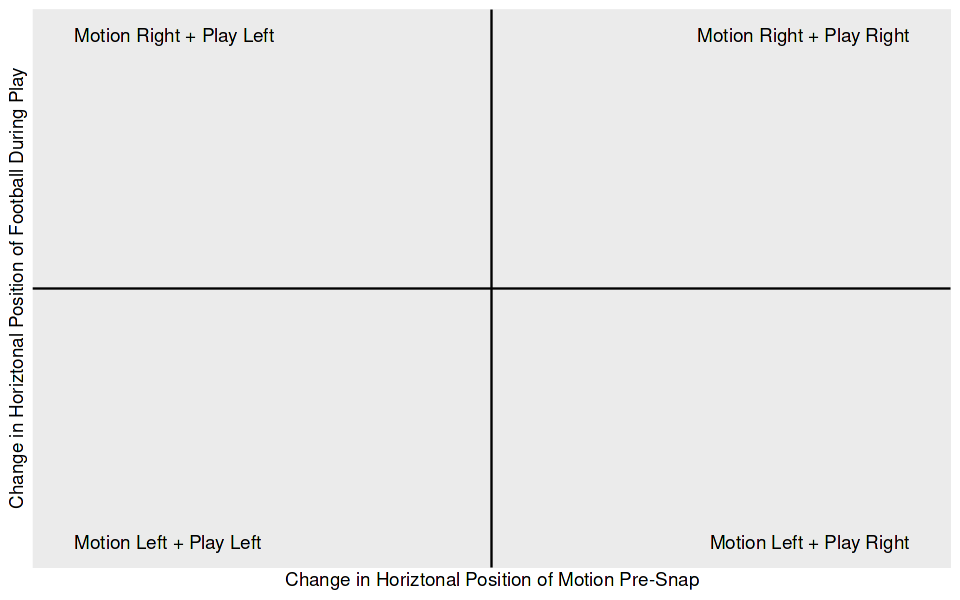

In [12]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot() +
    geom_vline(xintercept = 0) +
    geom_hline(yintercept = 0) +
    scale_x_continuous(
        name = 'Change in Horiztonal Position of Motion Pre-Snap',
        labels = c(),
        breaks = c()
    ) +
    scale_y_continuous(
        name = 'Change in Horiztonal Position of Football During Play',
        labels = c(),
        breaks = c()
    ) +
    geom_text(aes(x=1, y =1, label = 'Motion Right + Play Right', hjust = 'right')) +
    geom_text(aes(x=-1, y =1, label = 'Motion Right + Play Left', hjust = 'left')) +
    geom_text(aes(x=1, y =-1, label = 'Motion Left + Play Right', hjust = 'right')) +
    geom_text(aes(x=-1, y =-1, label = 'Motion Left + Play Left', hjust = 'left'))

Plotting the actual data along these dimensions for each team and coloring by run/pass, the data naturally groups into patterns that would have been too noisy to observe in aggregate. 

Some teams, like MIA and KC, utilize motion so frequently and with such parity that there is no clear relationship between their pre-snap motions and the play direction. For other teams, like NO and BUF, we do see stronger patterns to investigate further.

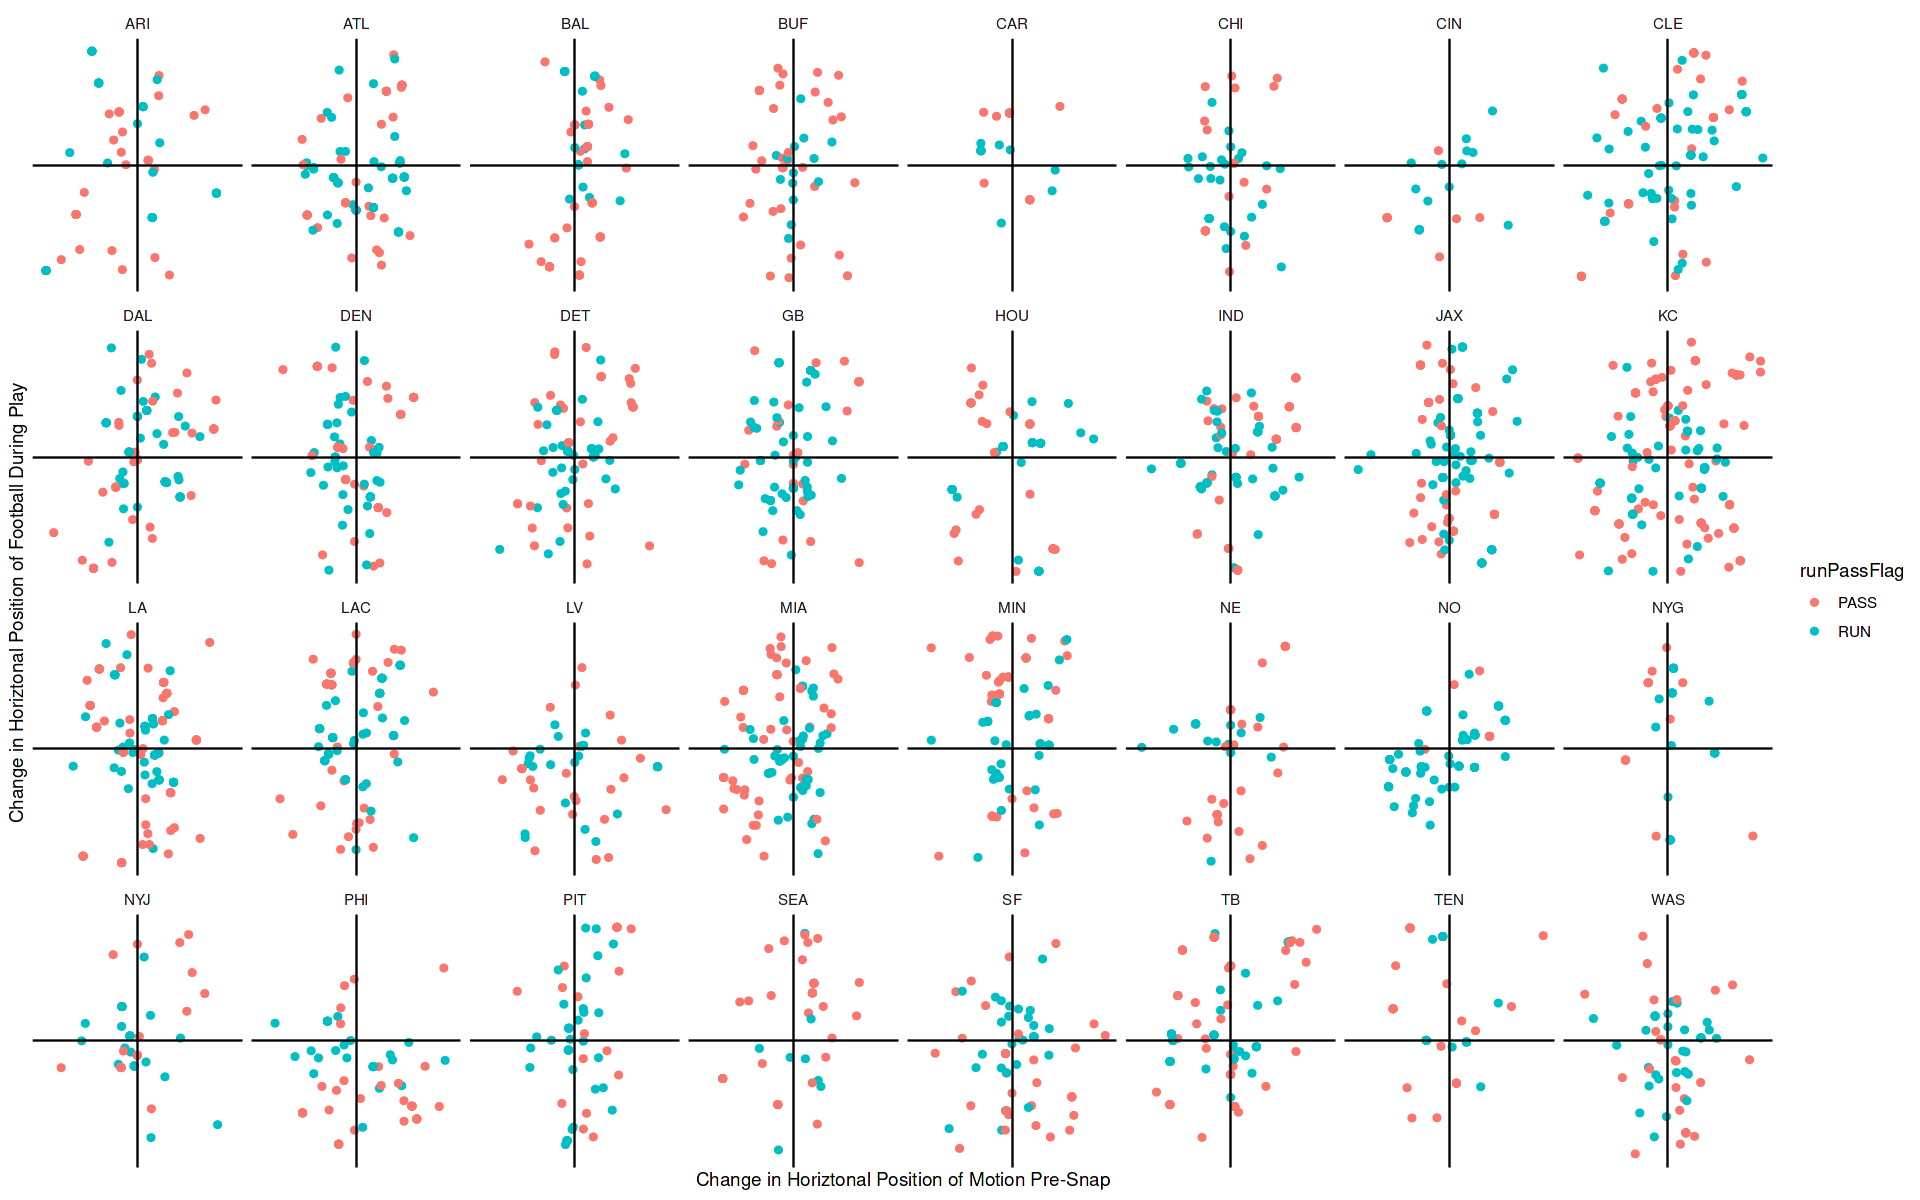

In [13]:
options(repr.plot.width = 16, repr.plot.height = 10)
dt %>%
    ggplot(aes(x=mtn_chg_y, y=change_in_y_during_play, color=runPassFlag)) +
    geom_point(na.rm = TRUE) +
    scale_x_continuous(
        name = 'Change in Horiztonal Position of Motion Pre-Snap',
        breaks = c(),
        limits = c(-20,20)
    ) +
    scale_y_continuous(
        name = 'Change in Horiztonal Position of Football During Play',
        breaks = c(),
        limits = c(-20,20)
    ) +
    geom_vline(xintercept = 0) +
    geom_hline(yintercept = 0) +
    facet_wrap(~possessionTeam, nrow = 4, ncol = 8) +
    theme(strip.text = element_text(size = 20, face = "bold"),
          legend.position = 'top', 
          legend.title = element_blank()
         ) +
    theme(
        legend.text = element_text(size = 20),
        axis.text.x = element_text(size = 20),
        axis.text.y = element_text(size = 20)
    ) +
    theme_minimal()

Starting with the Bills on the left, some patterns are immediately clear. They tend to use motion out of Shotgun (though this likely matches their overall playcalling) but they also almost always pass on plays with a player in motion at the snap. Further, when they do run from Shotgun, all four plays went up the middle very close to the starting position of the ball, likely through either A gap.

For the Saints on the right, we see the opposite. Almost every play where the ball is snapped with a player in motion results in a run, and they are usually in a pro-style Singleback formation. There does not appear to be as strong of a left/right tendency with their plays, however.

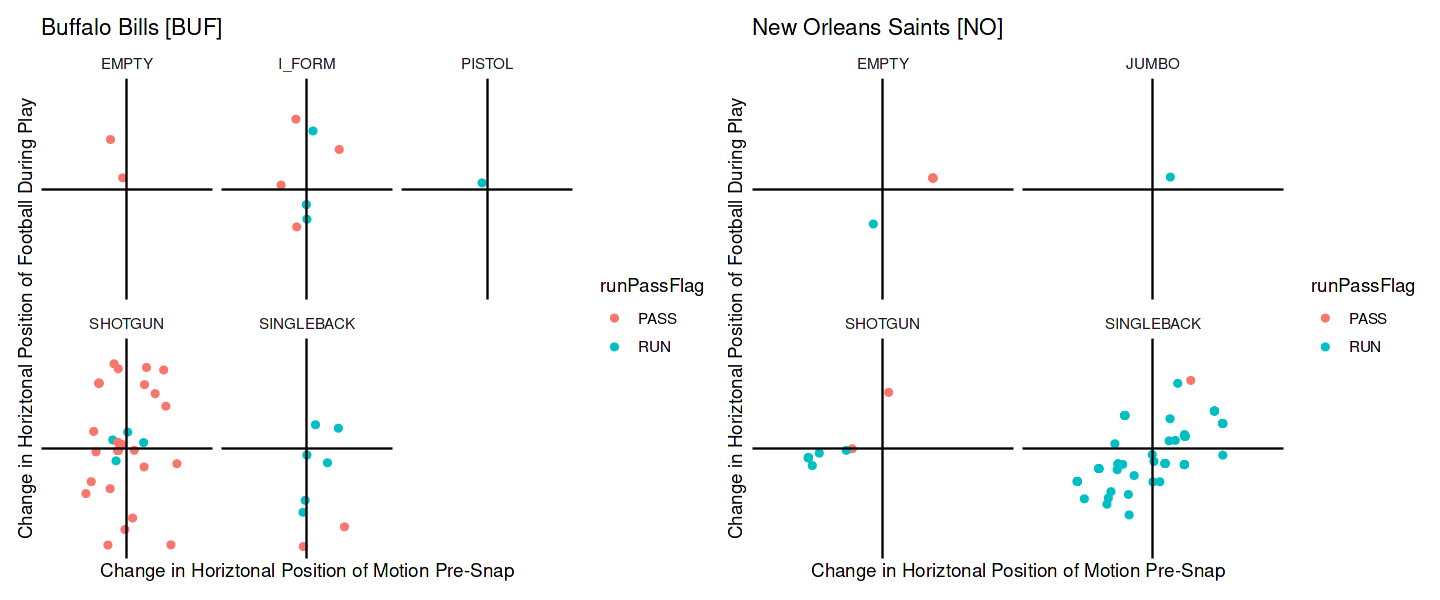

In [14]:
options(repr.plot.width = 12, repr.plot.height = 5)
BUF = dt %>%
    filter(possessionTeam == 'BUF') %>%
    ggplot(aes(x=mtn_chg_y, y=change_in_y_during_play, color=runPassFlag)) +
    geom_point(na.rm = TRUE) +
    scale_x_continuous(
        name = 'Change in Horiztonal Position of Motion Pre-Snap',
        breaks = c(),
        limits = c(-20,20)
    ) +
    scale_y_continuous(
        name = 'Change in Horiztonal Position of Football During Play',
        breaks = c(),
        limits = c(-20,20)
    ) +
    geom_vline(xintercept = 0) +
    geom_hline(yintercept = 0) +
    facet_wrap(~offenseFormation) +
    theme(
        axis.text.x = element_text(size = 14),
        axis.text.y = element_text(size = 14)
    ) +
    theme(legend.position = 'none') +
    ggtitle('Buffalo Bills [BUF]') +
    theme_minimal()

NO = dt %>%
    filter(possessionTeam == 'NO') %>%
    ggplot(aes(x=mtn_chg_y, y=change_in_y_during_play, color=runPassFlag)) +
    geom_point(na.rm = TRUE) +
    scale_x_continuous(
        name = 'Change in Horiztonal Position of Motion Pre-Snap',
        breaks = c(),
        limits = c(-20,20)
    ) +
    scale_y_continuous(
        name = 'Change in Horiztonal Position of Football During Play',
        breaks = c(),
        limits = c(-20,20)
    ) +
    geom_vline(xintercept = 0) +
    geom_hline(yintercept = 0) +
    facet_wrap(~offenseFormation) +
    theme(strip.text = element_text(size = 14, face = "bold"),
          legend.position = 'top', 
          legend.title = element_blank()
         ) +
    theme(
        legend.text = element_text(size = 14),
        axis.text.x = element_text(size = 14),
        axis.text.y = element_text(size = 14)
    ) +
    ggtitle('New Orleans Saints [NO]') +
    theme_minimal()

BUF + NO

Wrapping things up, we can distill one of the simplest takeaways (again the goal was a **heuristic**) into the chart below. The same data that was plotted on the scatterplots above is distilled into these bars which show the percentage of plays where the team in question runs the ball after beginning the play with a player in motion.

At the top of the chart, we find the Saints, who ran the ball 85% (!!!) of the time on motion plays. Second from the bottom, we find the Bills, who almost always pass, running on only 30% of motion plays.

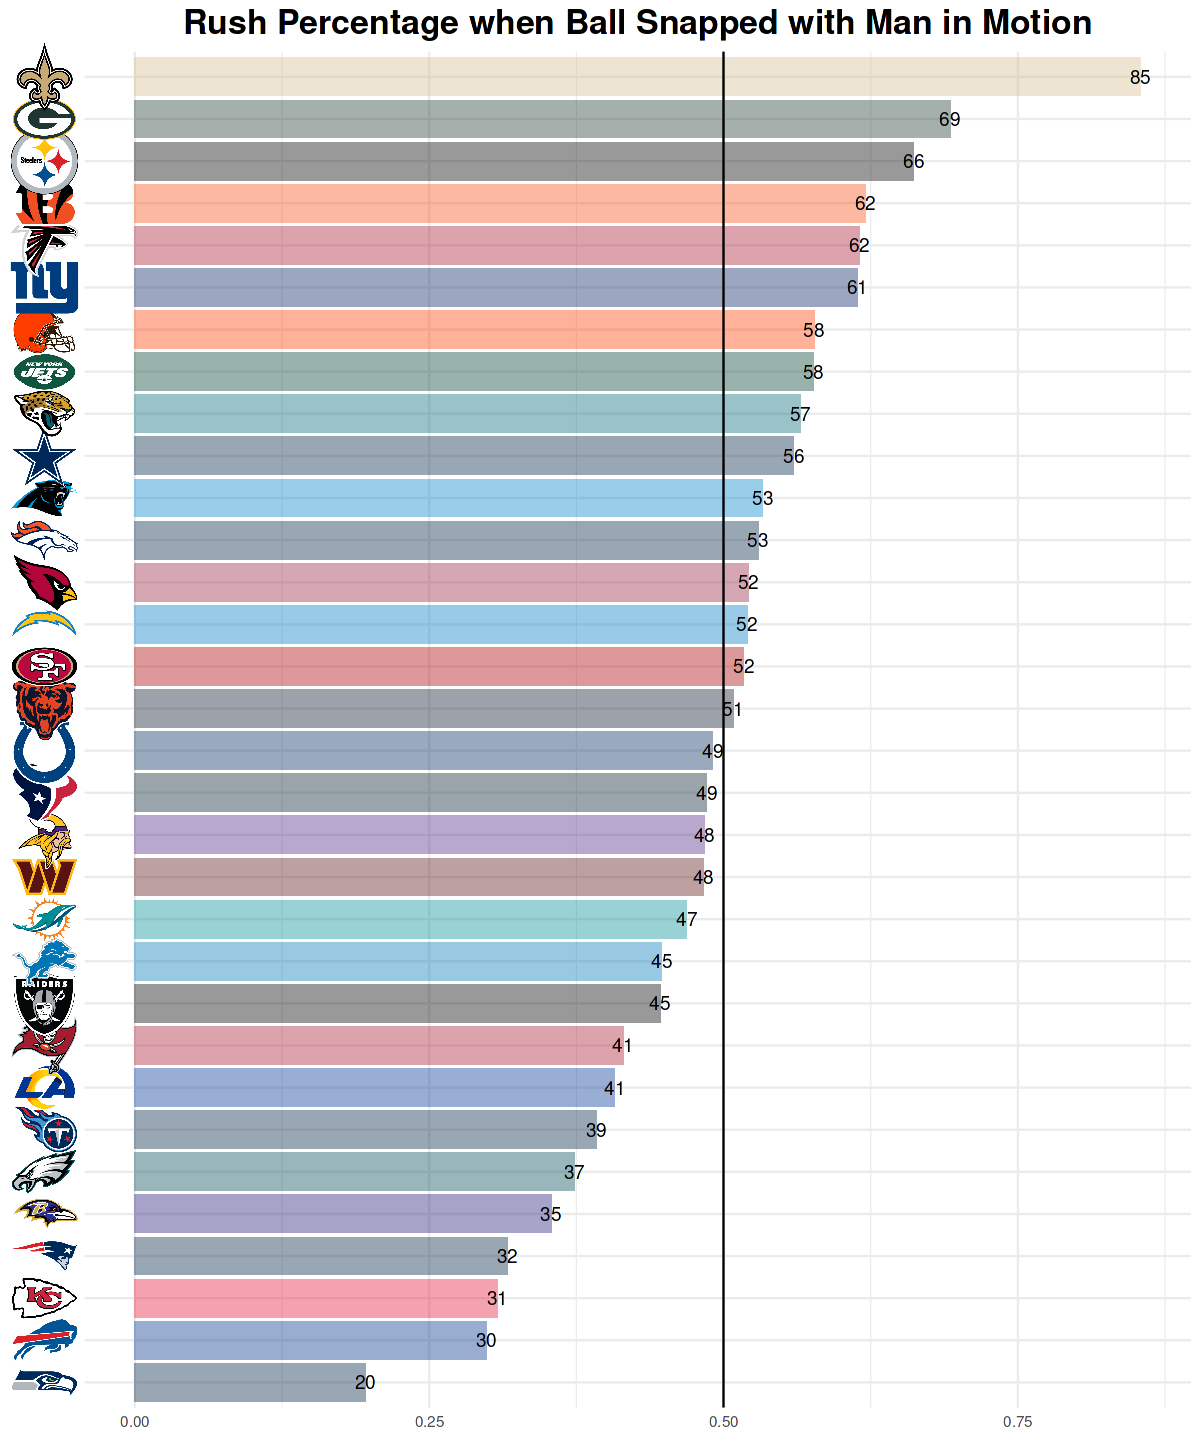

In [15]:
options(repr.plot.width = 10, repr.plot.height = 12)
rp_totals = dt %>%
    group_by(possessionTeam, runPassFlag) %>%
    summarize(play_type_total = n(), .groups = 'drop_last')

rp_totals %>%
    group_by(possessionTeam) %>%
    mutate(
        team_total = sum(play_type_total),
        pct = play_type_total / team_total
    ) %>%
    ungroup() %>%
    filter(runPassFlag == 'RUN') %>%
    mutate(
        possessionTeam = fct_reorder(possessionTeam, pct)
    ) %>%
    ggplot(aes(x = pct, y = possessionTeam)) +
    geom_bar(aes(fill = possessionTeam),  stat = 'identity') +
    geom_vline(xintercept = 0.5) +
    geom_text(aes(x=pct, y=possessionTeam, label = round(pct,2)*100)) +
    nflplotR::scale_color_nfl(type = "secondary") +
    nflplotR::scale_fill_nfl(alpha = 0.4) +
    labs(title = 'Rush Percentage when Ball Snapped with Man in Motion') +
    theme_minimal() +
    theme(axis.text.y = nflplotR::element_nfl_logo(size = 1.5),
          axis.title.y = element_blank(),
          axis.title.x = element_blank(),
          plot.title = element_text(
              size = 20,              
              hjust = 0.5,
              face = "bold"         
          )
         )

As belabored above, there is ample room for this analysis to better isolate the effects of pre-snap motions on play outcomes. 

Additional dimensions that I considered in varying degrees include:
* Contextual slices to account for field position and game state could help to identify tendencies in the red zone or on 3rd down
* Position of motion playe and other player dimensions (weight for example)
* Speed of motion, average speed of motion, and speed of motion relative to given player's top recorded speed
* Changes in direction (zig motions) vs straight-line motions
* Deep motions vs purely lateral movements (orbit vs shuffle)
* Using offensive concepts to better identify intended play direction

Despite these simplifications, there are clearly actionable insights to be found (heuristics!!!) in this view that could be utilized by teams in live action without sophisticated modeling.

Thanks for reading!